### Instacart Data Science Challenge
#### Author: Pablo Felgueres
#### July 19th, 2017
#### Description: Predict shopping time in store.

Folder structure:  
.  
\+ /data/
  
>  \+ order_items.csv  
   \+ test_trips.csv  
   \+ train_trips.csv  
  
\+ /notebooks/
>  \+ 01_PF_Instacart_Initial_EDA.csv **(You are here)**  
>  \+ 02_PF_Instacart_Modeling.csv 

\+ /src/
>  \+ model.py  
>  \+ preprocessing.py  
>  \+ split4validation.py

#### Initial hypotheses of correlated features to shopping time.

1) Volume of basket is proportional to shopping time  
2) The complexity of basket is proportional to shopping times: eg. number of distinct items, distinct. departments  
3) Reordering of items is inversely proportional to shopping time  
4) User's behavioral patterns are good proxies for shopping time: explore temportality of order (timeofday, dayofweek, etc), volume, previously unordered items  
5) Platform UX|UI changes impact shopping times: eg. avg. shopping time for first users vs. past users (cohort analysis)

#### We'll keep these on the back of our heads when exploring the dataset.

In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from os import path, listdir
%matplotlib inline

sns.set_style('white')

In [3]:
#Get file names.
files = [path.join('../data/', file) for file in sorted(listdir('../data/')) if file.endswith('csv')]
print files

['../data/order_items.csv', '../data/test_trips.csv', '../data/train_trips.csv']


In [4]:
#Load datasets
df_order_items = pd.read_csv(files[0])
df_test_trips = pd.read_csv(files[1])
df_train_trips = pd.read_csv(files[2])

In [5]:
#Let's start with a basic exploration on datatypes and missing values for the three datasets.
print '----HEAD'
print df_order_items.head(5)
print '----INFO & NULLS'
print df_order_items.info()

----HEAD
   trip_id  item_id department_name  quantity
0  3119513   368671         Produce      10.0
1  3120462   368671         Produce      10.0
2  3120473   368671         Produce      10.0
3  3121910   368671         Produce       6.0
4  3122332   368671         Produce      10.0
----INFO & NULLS
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2040286 entries, 0 to 2040285
Data columns (total 4 columns):
trip_id            int64
item_id            int64
department_name    object
quantity           float64
dtypes: float64(1), int64(2), object(1)
memory usage: 62.3+ MB
None


In [6]:
print '----HEAD'
print df_train_trips.head(5)
print '----INFO'
print df_train_trips.info()
print '----ISNULL & NULLS'
print df_train_trips.isnull().sum()

----HEAD
   trip_id  shopper_id fulfillment_model  store_id  shopping_started_at  \
0  3119519       48539           model_1         6  2015-09-01 07:03:56   
1  3119513        3775           model_1         1  2015-09-01 07:04:33   
2  3119516        4362           model_1         1  2015-09-01 07:23:21   
3  3119792       47659           model_1         1  2015-09-01 07:29:52   
4  3119922       11475           model_1         1  2015-09-01 07:32:21   

     shopping_ended_at  
0  2015-09-01 07:30:56  
1  2015-09-01 07:40:33  
2  2015-09-01 07:41:21  
3  2015-09-01 08:55:52  
4  2015-09-01 09:01:21  
----INFO
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117063 entries, 0 to 117062
Data columns (total 6 columns):
trip_id                117063 non-null int64
shopper_id             117063 non-null int64
fulfillment_model      117063 non-null object
store_id               117063 non-null int64
shopping_started_at    117063 non-null object
shopping_ended_at      117063 non-null objec

In [7]:
print '----HEAD'
print df_test_trips.head(5)
print '----INFO & NULLS'
print df_test_trips.info()

----HEAD
   trip_id  shopper_id fulfillment_model  store_id  shopping_started_at
0  4310899       60930           model_2       123  2015-11-16 07:00:12
1  4310904       59815           model_2       123  2015-11-16 07:00:12
2  4310907       60878           model_2       123  2015-11-16 07:00:13
3  4310911       60879           model_2       123  2015-11-16 07:00:13
4  4310328       66726           model_1         1  2015-11-16 07:01:08
----INFO & NULLS
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11647 entries, 0 to 11646
Data columns (total 5 columns):
trip_id                11647 non-null int64
shopper_id             11647 non-null int64
fulfillment_model      11647 non-null object
store_id               11647 non-null int64
shopping_started_at    11647 non-null object
dtypes: int64(3), object(2)
memory usage: 455.0+ KB
None


Missing data: Awesome! The dataset is clean of missing / erroneous data.  
  
Datatypes: We'd want to convert the shopping_started_at and shopping_ended_at into datetime objects instead of strings.
  
So let's go ahead and do that for the training dataset (keep that in mind for the source code).

In [8]:
#Change to datetime objects
df_train_trips.shopping_started_at = pd.DatetimeIndex(df_train_trips.shopping_started_at)
df_train_trips.shopping_ended_at = pd.DatetimeIndex(df_train_trips.shopping_ended_at)

In [9]:
#Create shopping time in seconds feature.
df_train_trips['shopping_time'] = (df_train_trips.shopping_ended_at - df_train_trips.shopping_started_at).dt.seconds

In [10]:
df_train_trips.shopping_time.head()

0    1620
1    2160
2    1080
3    5160
4    5340
Name: shopping_time, dtype: int64

Since we are going to predict shopping time for each trip, let's look at how many trips we have on the train and test set.


In [11]:
train_trips = df_train_trips.trip_id.unique().shape[0]
print 'Unique trips in train: {0: ,}'.format(train_trips)
print
test_trips = df_test_trips.trip_id.unique().shape[0]
print 'Unique trips in test: {0: ,}'.format(test_trips)
print
total_trips = train_trips + float(test_trips)
print 'Total trips in train & test: {0: ,}'.format(total_trips)
print
split = test_trips / total_trips
print 'Train / Test split: {0: .1%} / {1:.1%}'.format(train_trips/total_trips, test_trips/total_trips)

Unique trips in train:  117,063

Unique trips in test:  11,647

Total trips in train & test:  128,710.0

Train / Test split:  91.0% / 9.0%


So we should have same total amount of unique trips in the orders items

In [12]:
print 'Unique trips in items: {0: ,}'.format(df_order_items.trip_id.unique().shape[0])

Unique trips in items:  128,710


Good! Now let's look if the unique trips intersect between them eg. we are looking at the same data points.

In [13]:
print 'train-orders-intersect {:.0%}'.format(df_train_trips.trip_id.isin(df_order_items.trip_id).sum() / float(train_trips))
print 'test-orders-intersect {:.0%}'.format(df_test_trips.trip_id.isin(df_order_items.trip_id).sum() / float(test_trips))

train-orders-intersect 100%
test-orders-intersect 100%


Now let's look at the distributions of the trips to find useful features for our model.  
  
A good idea would be to follow the stated hypotheses at the beginning as a guide instead of fishing around.

#### Important note: To avoid info leakage between training and testing, I'll work only with the training section of the order dataset.

In [14]:
del df_test_trips

In [15]:
df_order_items_train = df_order_items.loc[df_order_items.trip_id.isin(df_train_trips.trip_id)].copy()

### Hypothesis 1: Basket volume is proportional to shopping time

In [16]:
#Let's group by trip id and compute quantity.
basket_volume = df_order_items_train.groupby('trip_id')['quantity'].sum().to_frame().reset_index().rename(columns = {'quantity': 'basket_volume'})

In [17]:
basket_volume.head()

,trip_id,basket_volume
0,3119513,183.0
1,3119516,9.0
2,3119518,21.0
3,3119519,39.0
4,3119520,36.0


In [18]:
#Merge to train_trips to start building a useful feature space.
df = basket_volume.merge(df_train_trips, left_on='trip_id', right_on='trip_id', how='left')

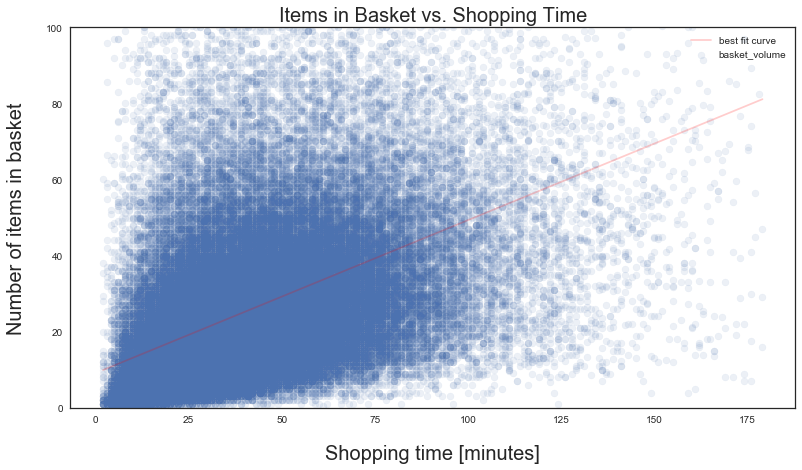

In [19]:
fig = plt.figure(figsize=(13,7))
ax = fig.add_subplot(111)
ax.scatter(df.shopping_time /60., df.basket_volume, alpha=0.1)
ax.plot(np.unique(df.shopping_time.values / 60), np.poly1d(np.polyfit(df.shopping_time.values /60., df.basket_volume.values, 1))(np.unique(df.shopping_time.values/60.)), c = 'r', alpha =0.2, label = 'best fit curve')
ax.set_ylabel('Number of items in basket', labelpad=20, fontsize = 20)
ax.set_xlabel('Shopping time [minutes]', labelpad=20, fontsize = 20)
ax.set_ylim(0,100)
# ax.set_xlim(0,150)
plt.title('Items in Basket vs. Shopping Time', fontsize = 20)
plt.legend()

Interesting! 
Looking at the bulk of trips, which have a basket between [0-40], there is definitely correlation between basket size and shopping time.  
Let's quantify how much.  

In [20]:
print 'The pearson coeff for basket size vs shopping time is {0: .1%}'.format(df.basket_volume.corr(df.shopping_time))

The pearson coeff for basket size vs shopping time is  39.5%


However, volume will only tells us a partial story, we'd want to include some proxy for complexity of the basket and economic value.  
Since we don't have economic value in this dataset, let's look at some proxy for complexity of basket.

### Hypothesis 2: Basket complexity is proportional to shopping time

Considering the data only has department and item id of the products, I will analyze the cross relationships between these 2 features agains shopping time.

I'll look into item diversity and department diversity.

In [21]:
print '# of Items: {0}'.format(df_order_items_train.item_id.unique().shape[0])

# of Items: 94678


In [22]:
#Let's get the count of items by trip.
item_count = df_order_items_train.groupby('trip_id')['item_id'].nunique().reset_index().rename(columns ={'item_id': 'item_cnt'})

In [23]:
#Some stats
item_count.item_cnt.describe()

count    117063.000000
mean         15.888197
std          11.962306
min           1.000000
25%           8.000000
50%          13.000000
75%          21.000000
max         201.000000
Name: item_cnt, dtype: float64

In [24]:
#Plot the distribution of distinct items per trip
item_dist = item_count.item_cnt.value_counts().to_frame().reset_index().rename(columns = {'index': 'Num_items', 'item_cnt': 'Frequency'})

In [25]:
np.arange(min(item_dist.Num_items), max(item_dist.Num_items)+1, 5)

array([  1,   6,  11,  16,  21,  26,  31,  36,  41,  46,  51,  56,  61,
        66,  71,  76,  81,  86,  91,  96, 101, 106, 111, 116, 121, 126,
       131, 136, 141, 146, 151, 156, 161, 166, 171, 176, 181, 186, 191,
       196, 201])

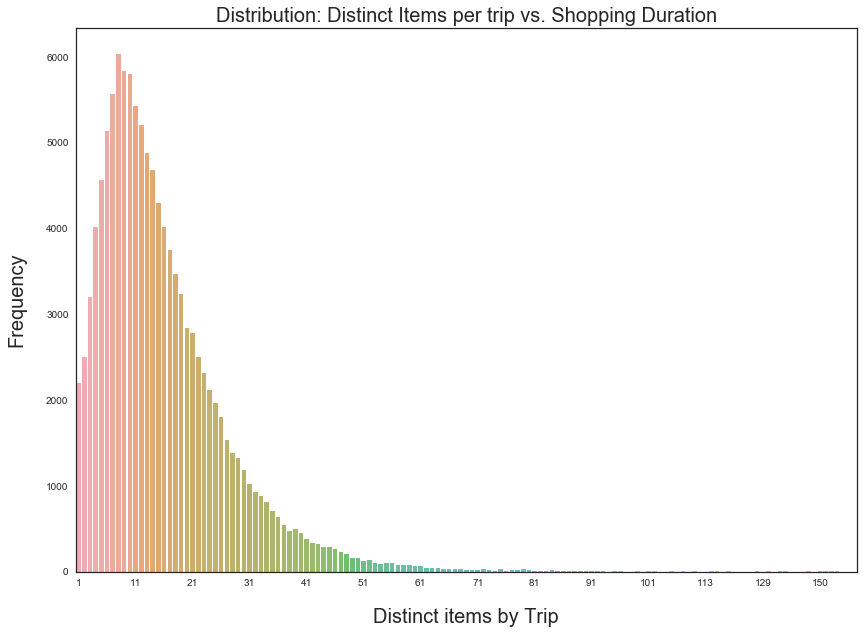

In [26]:
fig = plt.figure(figsize=(14,10))
ax_dist_dpt = fig.add_subplot(111)
sns.barplot(item_dist.Num_items, item_dist.Frequency, alpha=0.8, ax = ax_dist_dpt)
ax_dist_dpt.set_ylabel('Frequency', fontsize=20, labelpad=20)
ax_dist_dpt.set_xlabel('Distinct items by Trip', fontsize=20, labelpad=20)
ax_dist_dpt.set_title('Distribution: Distinct Items per trip vs. Shopping Duration', fontsize =20)
for ind, label in enumerate(ax_dist_dpt.get_xticklabels()):
    if ind % 10 == 0:  # every 10th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)

Let's divide by quantiles and see their correlation to shopping time.

In [27]:
#Merge item per trip count to main df
df = df.merge(item_count, left_on = 'trip_id', right_on = 'trip_id', how = 'left')

In [28]:
del item_count

In [29]:
#Divide into deciles and plot mean time boxplots.
dis_item = df.loc[:, ['shopping_time','item_cnt']].copy()
dis_item['deciles'] = pd.qcut(dis_item.item_cnt, 10)

In [30]:
font_params = {'fontsize': 20}

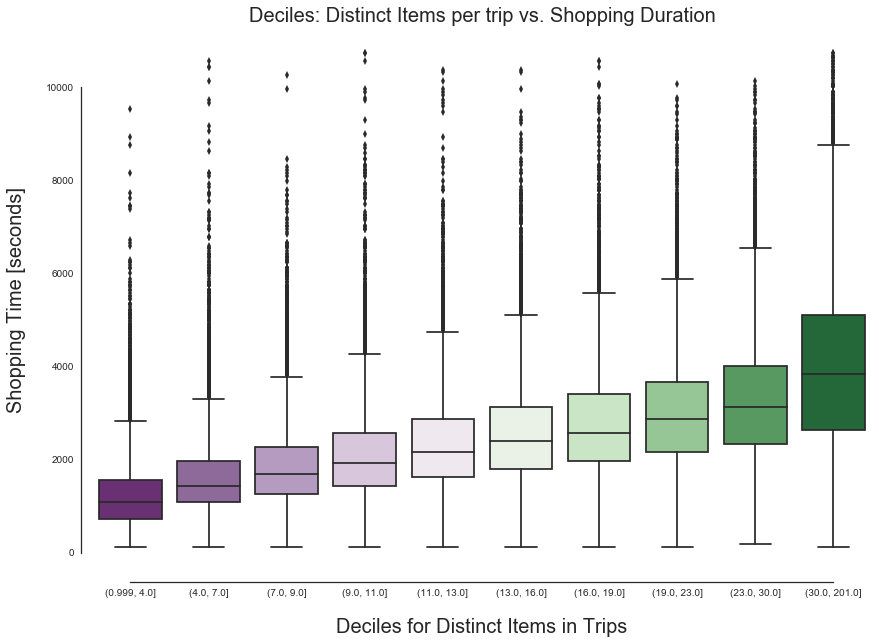

In [31]:
fig, ax = plt.subplots()
fig.set_size_inches((14,10))
sns.boxplot(x="deciles", y="shopping_time", data=dis_item, palette="PRGn", ax = ax)
sns.despine(offset=10, trim=True)
ax.set_ylabel('Shopping Time [seconds]', font_params, labelpad=20)
ax.set_xlabel('Deciles for Distinct Items in Trips', font_params, labelpad=20)
ax.set_title('Deciles: Distinct Items per trip vs. Shopping Duration', font_params)

Interesting! Few things to note here.  
  
- 10% of the population has a range of 170 distint items, while 90% are within 3-4 items.  
  
  
- The variance for those trips is far greater as well, we expect them to be harder to predict.   
  
  
- Linear effect as expected, eg. the more distinct items the greater time shopping.  
  
  
- There are a great number of "outliers" if we considered this data to be normally distributed. As expected, this variable only partially good as predictor.
  
  
- It's interesting to see that although the concentration of density increases monotonically among buckets, the range that they span in shopping duration is very similar!  


In [32]:
print 'The pearson coeff for distinct items in basket vs shopping time is {0: .1%}'.format(df.item_cnt.corr(df.shopping_time))

The pearson coeff for distinct items in basket vs shopping time is  50.7%


In [33]:
del dis_item

So it seems to be a sizeable effect between shopping time and the distinct items on the basket.  
It would even more useful to find some weights to departments and see the cross efect to this.  
  
One way to do so is to asign a weight based on the overall frequency of items bought from a department.  
  
### My hypothesis there would be that odd purchases are time consuming and would be reflected on departments where users don't buy items regularly. 

I'll build this feature if time allows.

Let's continue with something similar for this departments now.

In [34]:
print '# of Dptmnts: {0}'.format(df_order_items_train.department_name.unique().shape[0])

# of Dptmnts: 83


In [35]:
#Let's get the count of departments by trip.
dpt_count = df_order_items_train.groupby('trip_id')['department_name'].nunique().reset_index().rename(columns ={'department_name': 'dpts_cnt'})

In [36]:
#Plot the distribution of distinct dpts per trip
dpt_dist = dpt_count.dpts_cnt.value_counts().to_frame().reset_index().rename(columns = {'index': 'Num_dpts', 'dpts_cnt': 'Frequency'})

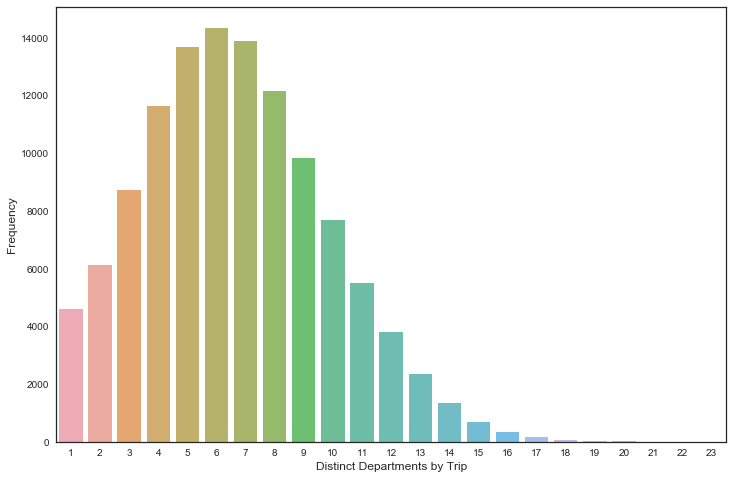

In [37]:
fig = plt.figure(figsize=(12,8))
ax_dist_dpt = fig.add_subplot(111)
sns.barplot(dpt_dist.Num_dpts, dpt_dist.Frequency, alpha=0.8, ax = ax_dist_dpt)
ax_dist_dpt.set_ylabel('Frequency', fontsize=12)
ax_dist_dpt.set_xlabel('Distinct Departments by Trip', fontsize=12)
plt.show()

Interesting, so the expected number of dpts per trip is aprox. 6 or 7. Let's see if there is any correlation between this feature and shopping time.

In [38]:
#Merge deperment per trip count to main df
df = df.merge(dpt_count, left_on = 'trip_id', right_on = 'trip_id', how = 'left')

In [39]:
del dpt_count

In [40]:
df.columns

Index([u'trip_id', u'basket_volume', u'shopper_id', u'fulfillment_model',
       u'store_id', u'shopping_started_at', u'shopping_ended_at',
       u'shopping_time', u'item_cnt', u'dpts_cnt'],
      dtype='object')

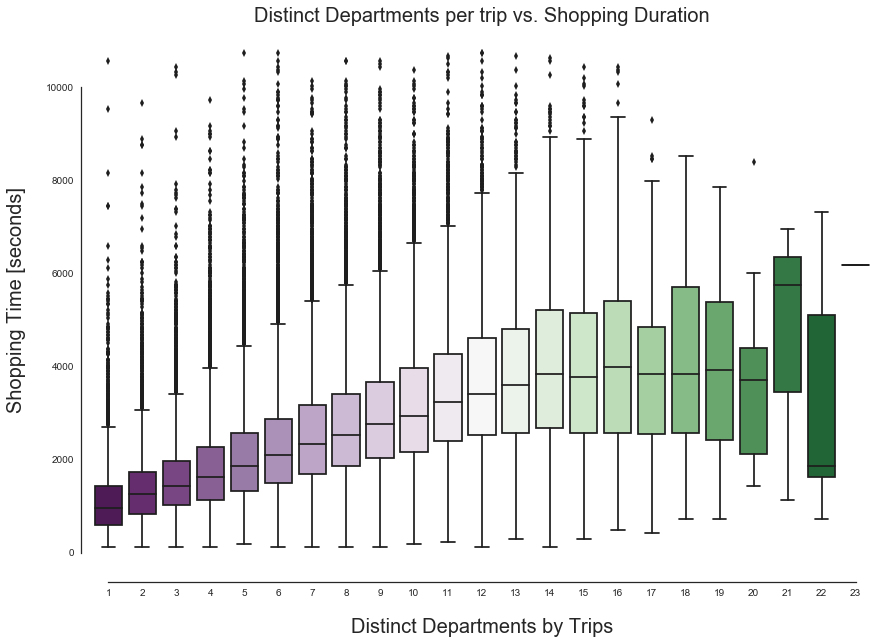

In [41]:
fig, ax = plt.subplots()
fig.set_size_inches((14,10))
sns.boxplot(x="dpts_cnt", y="shopping_time", data=df, palette="PRGn", ax = ax)
sns.despine(offset=10, trim=True)
ax.set_ylabel('Shopping Time [seconds]', font_params, labelpad=20)
ax.set_xlabel('Distinct Departments by Trips', font_params, labelpad = 20)
ax.set_title('Distinct Departments per trip vs. Shopping Duration', font_params)

In [42]:
print 'The pearson coeff for distinct departments per basket vs shopping time is {0: .1%}'.format(df.dpts_cnt.corr(df.shopping_time))

The pearson coeff for distinct departments per basket vs shopping time is  48.8%


#### Great! So as the number of departments (proxy for shopping complexity) is increased, there is an effect on the shopping time.  

### Hypothesis 3: Reordering items is inversely proportional to shopping time.

It's crucial that we have same user reordering on the dataset so let's look into that.

In [43]:
df.groupby('shopper_id').size().head(10)

shopper_id
52      65
64       4
89     115
95     116
100    137
109     25
130     68
135    320
148     91
151    150
dtype: int64

Good! So we do have multiple trips for the same user. Let's do some transformations to get a metric of reordering frequency. 

In [44]:
#Merge order information with train dataset
reorders = df_order_items_train.merge(df.loc[:, ['trip_id', 'shopper_id']], left_on = 'trip_id', right_on = 'trip_id', how = 'left')

In [45]:
#For each shopper, for each of item, compute the trips where it has been shopped.
reordered_items = reorders.groupby(['shopper_id', 'item_id'])['trip_id'].apply(lambda x: x.count()).to_frame()

In [46]:
reordered_items.head(10)

trip_id
shopper_id item_id         
52         489            1
           547            1
           1428           1
           1597           1
           1661           1
           1669           1
           1670           1
           2853           1
           3026           1
           3030           2

Excellent, this tells you how many trips have had X item in it.

So we can proceed in many ways to use the reordering metric, just as before we could do some cross effects with departments for each of the items.  
  
#### Due to the nature of this sprint, I'll only calculate a value that translates to reorder frequency. It's the summation of reordered acounts normalized to the total number of products a person has ordered.

#### 1 corresponds to a user which doesn't show any reordering behaviour, greater numbers correspond to reordering factor by user

In [47]:
#Calculate reordering factor.
reordered_items = reordered_items.groupby('shopper_id')['trip_id'].sum() / reordered_items.groupby('shopper_id')['trip_id'].apply(lambda x: np.sum([1 for e in x]))

In [48]:
reordered_factor = reordered_items.to_frame().rename(columns = {'trip_id': 'reorder_factor'})
reordered_factor.columns = ['reorder_factor']
reordered_factor.reset_index(inplace =True)

In [49]:
#Merge to main dataframe
df = df.merge(reordered_factor, left_on = 'shopper_id', right_on = 'shopper_id', how = 'left')

In [50]:
#Divide into deciles and plot mean time boxplots.
reorder = df.loc[:,['reorder_factor','shopping_time']]
reorder.reorder_factor = (reorder.reorder_factor)
reorder['deciles'] = pd.qcut(reorder.reorder_factor, 10)

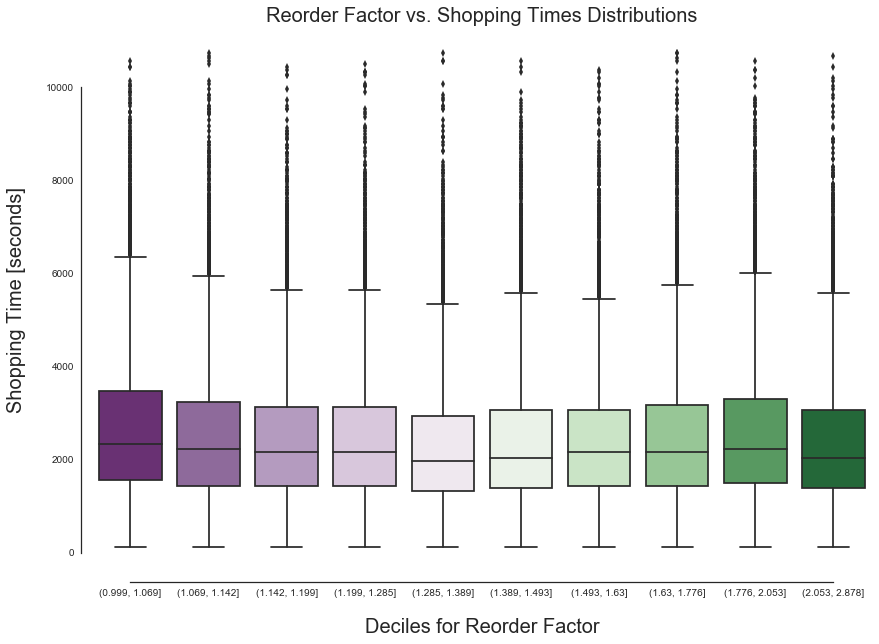

In [51]:
fig, ax = plt.subplots()
fig.set_size_inches((14,10))
sns.boxplot(x="deciles", y="shopping_time", data=reorder, palette="PRGn", ax = ax)
sns.despine(offset=10, trim=True)
ax.set_ylabel('Shopping Time [seconds]', font_params, labelpad=20)
ax.set_xlabel('Deciles for Reorder Factor', font_params, labelpad=20)
ax.set_title('Reorder Factor vs. Shopping Times Distributions', font_params)

Interesting! The reorder factor is indeed inversely proportional to the shopping time!

In [52]:
grouped_df = reorder.groupby(["deciles"])["shopping_time"].aggregate("median").reset_index()

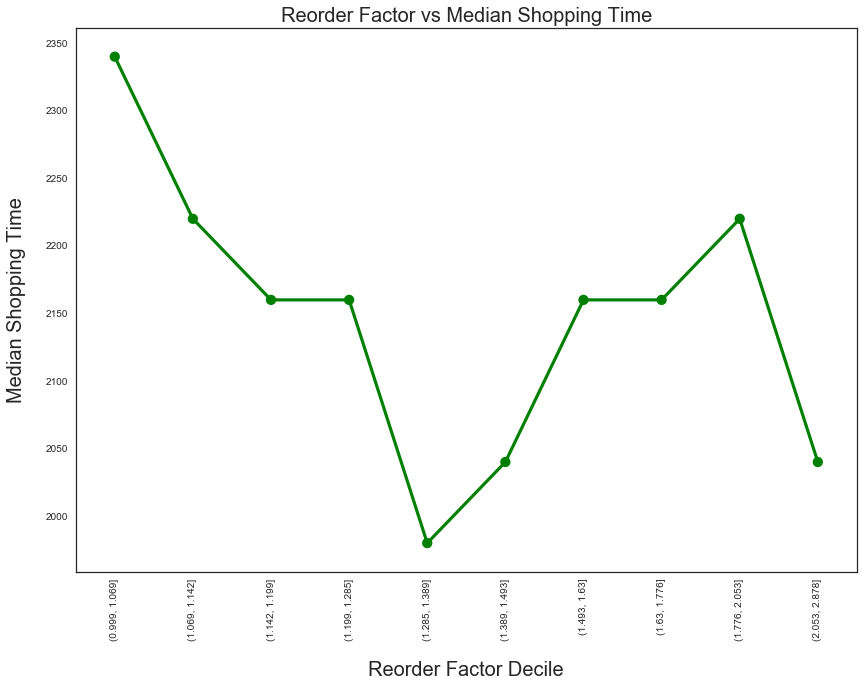

In [53]:
plt.figure(figsize=(14,10))
sns.pointplot(grouped_df.deciles, grouped_df['shopping_time'].values, color = 'green')
plt.ylabel('Median Shopping Time', fontsize=20, labelpad =20)
plt.xlabel('Reorder Factor Decile', fontsize=20, labelpad = 20)
plt.title("Reorder Factor vs Median Shopping Time", fontsize=20)
plt.xticks(rotation='vertical')
plt.show()

In [54]:
print 'Reorder corr with shopping time: {0:,.1%}'.format(df.reorder_factor.corr(df.shopping_time))

Reorder corr with shopping time: -2.2%


There is definitely opportunity to explore deeper this reordering effect.

### Hypothesis 4: User's behavioral patterns are good proxies for shopping time: explore temportality effects (timeofday, dayofweek, mixed effects)

In [55]:
#From dataframe let's add the temporal values, dayofweek, hour of day and timeofyear is a good start. 
df['dow'] = df.shopping_started_at.dt.dayofweek
df['hourofday'] = df.shopping_started_at.dt.hour
df['month'] = df.shopping_started_at.dt.month

In [56]:
mean_shopping_time = df.groupby(['dow', 'hourofday'])['shopping_time'].apply(np.mean).reset_index()

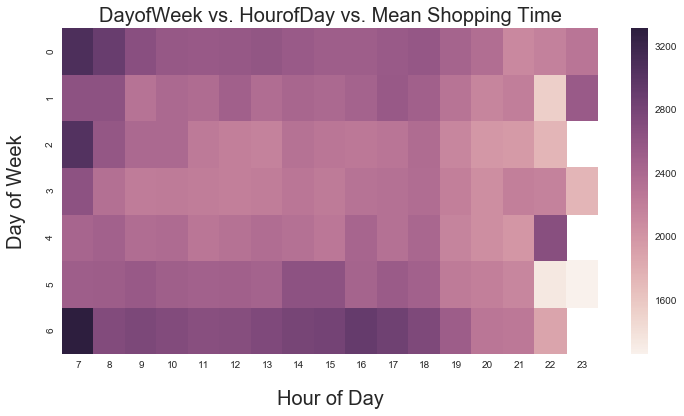

In [57]:
mean_shopping_time = mean_shopping_time.pivot('dow', 'hourofday', 'shopping_time')
plt.figure(figsize=(12,6))
sns.heatmap(mean_shopping_time)
plt.title("DayofWeek vs. HourofDay vs. Mean Shopping Time", font_params)
plt.ylabel("Day of Week", font_params, labelpad=20)
plt.xlabel("Hour of Day", font_params, labelpad=20)

As one might expect, people tend to shop more time towards the weekends.  
It's interesting to see the 7am trend but might be cause by some outlier data points, let's dig into that bringing the distribution of the trips.

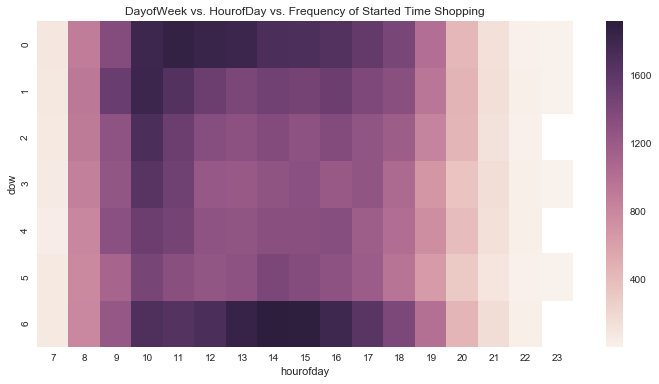

In [58]:
frequency_shopping_time = df.groupby(['dow', 'hourofday'])['shopping_time'].apply(np.size).reset_index()
frequency_shopping_time = frequency_shopping_time.pivot('dow', 'hourofday', 'shopping_time')
plt.figure(figsize=(12,6))
sns.heatmap(frequency_shopping_time)
plt.title("DayofWeek vs. HourofDay vs. Frequency of Started Time Shopping")

People tipically shop either on Monday morning or Sundays evening.  
This is also interesting since it shows the plot above shows a small fraction of the population have the max. time of shopping.
  
Let's see what happens if we weight by the mean by frequency. 

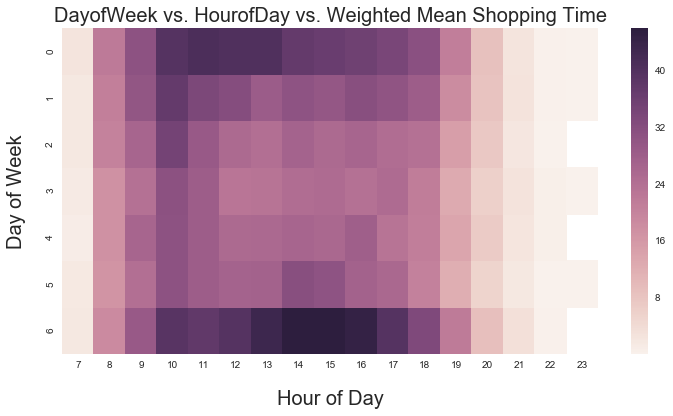

In [59]:
weighted_shopping_time = df.groupby(['dow', 'hourofday'])['shopping_time'].apply(lambda x: (np.size(x) / float(train_trips)) * x.mean()).reset_index()
weighted_shopping_time = weighted_shopping_time.pivot('dow', 'hourofday', 'shopping_time')
plt.figure(figsize=(12,6))
sns.heatmap(weighted_shopping_time)
plt.title("DayofWeek vs. HourofDay vs. Weighted Mean Shopping Time", font_params)
plt.ylabel("Day of Week", font_params, labelpad=20)
plt.xlabel("Hour of Day", font_params, labelpad=20)

Great! This feels more of a representative measure of shopping habits of the entire population.  
However, we should consider this for hour model, maybe clustering the users by the some of the attributes we've found could help to segment the feature space and perhaps creating a few models to predict for shopping time.  

In [60]:
#Let's create some bins to divide on hours.
df['hourbins'] = pd.cut(df.hourofday, bins=4)

In [61]:
#Create categorical where day is Monday or Sunday
df['is_busy'] = np.where(df.dow.isin([1,6]), 1, 0 )

In [62]:
#checking on the mean shopping time by 
store_mean = df.groupby('store_id')['shopping_time'].apply(lambda x: np.mean(x))

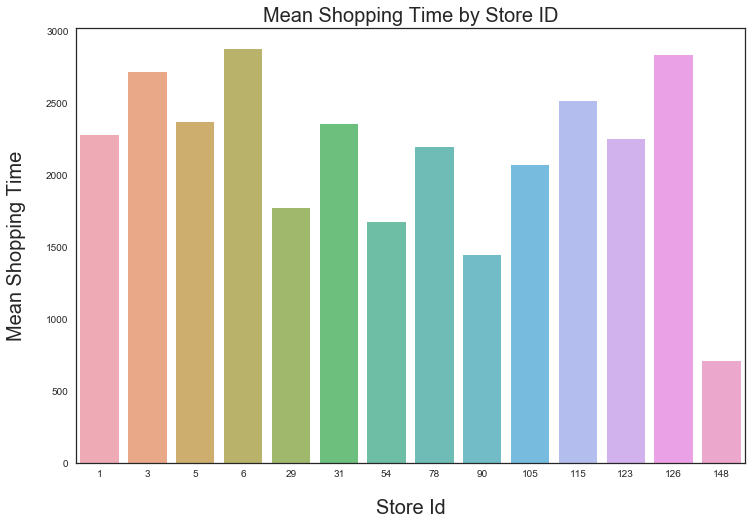

In [63]:
fig = plt.figure(figsize=(12,8))
ax_dist_dpt = fig.add_subplot(111)
sns.barplot(store_mean.index, store_mean.values, alpha=0.8, ax = ax_dist_dpt)
ax_dist_dpt.set_ylabel('Mean Shopping Time', fontsize=20, labelpad=20)
ax_dist_dpt.set_xlabel('Store Id', fontsize=20, labelpad=20)
plt.title('Mean Shopping Time by Store ID', fontsize = 20)
plt.show()

Cohort Analysis

I want to capture the effect of users shopping time as they use the platform.

In [64]:
#Get range of dates in the dataset
print 'min: ', df.shopping_started_at.min()
print 'min: ', df.shopping_started_at.max()

min:  2015-09-01 07:03:56
min:  2015-11-15 22:17:32


Since it's only two months of data, instead of monthly progression I'll capture daily progression.

In [65]:
# Parse for monthly rollups
df['trip_period'] = df.shopping_started_at.apply(lambda x: x.strftime('%Y-%m-%d-%a'))

In [66]:
# Get their first transaction by grouping by and min as aggregating function.
first_trip = df.groupby(by='shopper_id')['shopping_started_at'].min().to_frame()
#Change the column name 
first_trip.columns = ['first_trip']

In [67]:
df = df.merge(first_trip, left_on='shopper_id', right_index=True)
df['cohortGroup'] = df.first_trip.apply(lambda x: x.strftime('%m-%d'))

In [68]:
cohorts = df.groupby(['cohortGroup', 'trip_period'])
cohorts = cohorts.agg({'shopper_id': pd.Series.nunique,
                       'shopping_time': np.mean})

In [69]:
### Label CohortPeriod for each Cohort
def cohort_period(df):
    '''
    Creates a `CohortPeriod` column, which is the Nth period based on the user's first trip
    Params
    ------
    df: Dataframe
        Already grouped in cohorts dataframe
    Output
    ------
    Returns dataframe with numbered periods. 
    '''
    df['cohortPeriod'] = np.arange(len(df)) + 1
    
    return df

In [70]:
cohorts = cohorts.groupby(level=0).apply(cohort_period)

In [71]:
# reindex the DataFrame
cohorts.reset_index(inplace=True)
cohorts.set_index(['cohortGroup', 'cohortPeriod'], inplace=True)

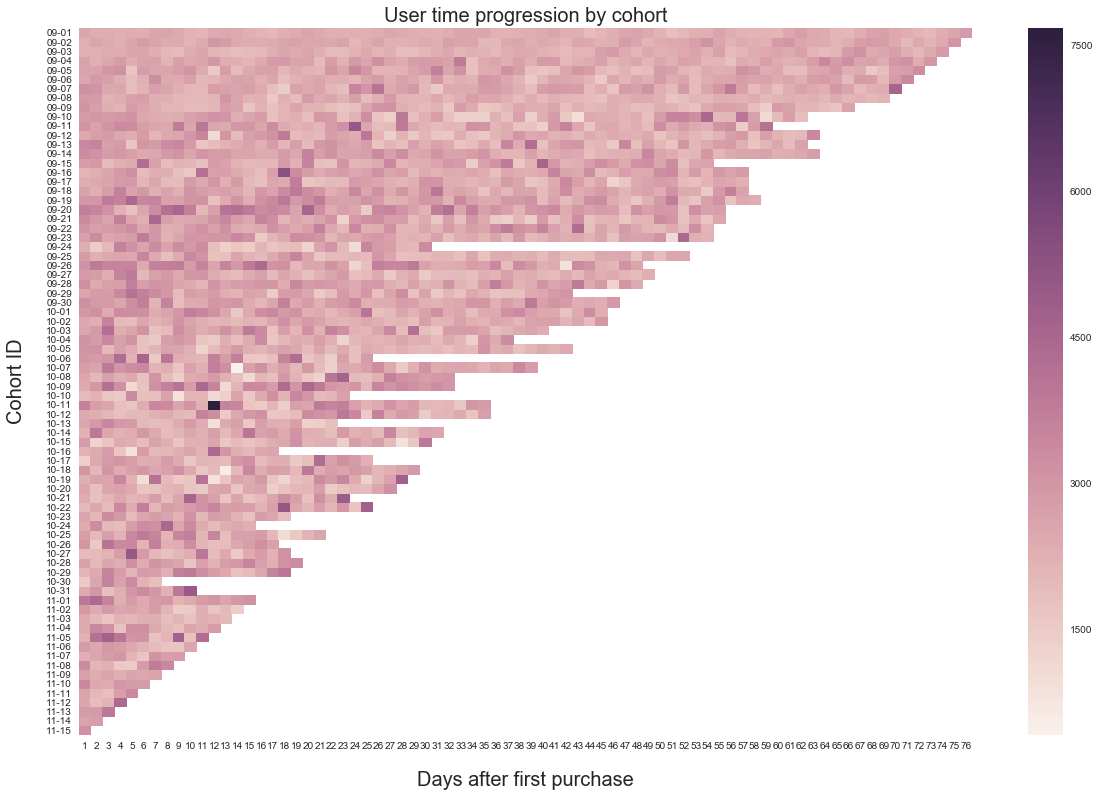

In [72]:
plt.figure(figsize=(20, 13))
sns.heatmap(cohorts.shopping_time.unstack(0).T, mask=cohorts.shopping_time.unstack(0).T.isnull(), fmt='.0%')
plt.title("User time progression by cohort", font_params)
plt.ylabel("Cohort ID", font_params, labelpad=20)
plt.xlabel("Days after first purchase", font_params, labelpad=20)

This plot shows the time duration of a cohort as time progresses. I was expecting a notable fadeout, eg. the more recurrent a shopper reuses the platorm, the lesser the shopping time. It is not clear to me if I can see that trend in here. I should probably resample by weeks instead of days.

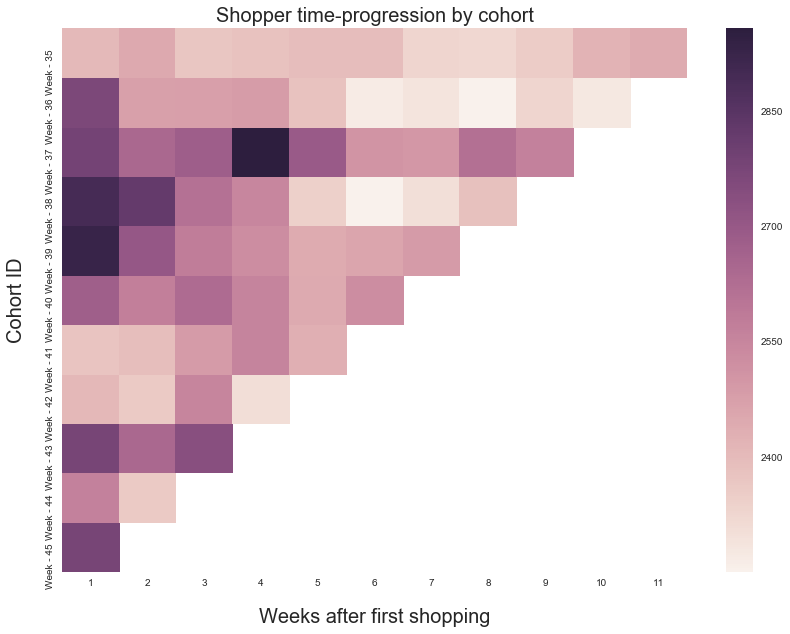

In [73]:
df_weekly = df

df_weekly['trip_period'] = df_weekly.shopping_started_at.apply(lambda x: x.strftime('%W'))
# Get their first transaction by grouping by and min as aggregating function.
first_trip = df_weekly.groupby(by='shopper_id')['shopping_started_at'].min().to_frame()
#Change the column name 
first_trip.columns = ['first_trip']
#Merge to 
df_weekly = df_weekly.merge(first_trip, left_on='shopper_id', right_index=True)
df['cohortGroup'] = df.first_trip.apply(lambda x: x.strftime('Week - %W'))

cohorts = df.groupby(['cohortGroup', 'trip_period'])
cohorts = cohorts.agg({'shopper_id': pd.Series.nunique,
                       'shopping_time': np.mean})

cohorts = cohorts.groupby(level=0).apply(cohort_period)

#reindex the DataFrame
cohorts.reset_index(inplace=True)
cohorts.set_index(['cohortGroup', 'cohortPeriod'], inplace=True)

#Plot
plt.figure(figsize=(14, 10))
sns.heatmap(cohorts.shopping_time.unstack(0).T, mask=cohorts.shopping_time.unstack(0).T.isnull(), fmt='.0%')
plt.title("Shopper time-progression by cohort", font_params)
plt.ylabel("Cohort ID", font_params, labelpad=20)
plt.xlabel("Weeks after first shopping", font_params, labelpad=20)

That's better! At least there are two interesting effects happening here. 

1) Shoppers that made their first shopping during weeks 36 - 39 share high shopping duration. It would be interesting to know what they share in common. 

2) It is visible that as time progresses, user's do get more time efficient at the platform.

With this information, let's model!